Mainly an effort to try to reproduce this notebook (https://github.com/desihub/desisim/blob/master/doc/nb/bgs-reference-spectra.ipynb) in order to use the DESI pipeline for the project. Eventually the goal is to also reproduce this notebook: https://github.com/desihub/desisim/blob/master/doc/nb/bgs-redshift-efficiency.ipynb. 

In [2]:
import os
os.environ['DESI_BASIS_TEMPLATES']='/Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3'
import sys
import numpy as np 
from astropy.table import vstack
from scipy.spatial import cKDTree as KDTree
# --local--
from speclite import filters
from desimodel.io import load_throughput
from desisim.io import empty_metatable
from desisim.io import read_basis_templates
from desisim.templates import BGS
import desitarget.mock.quicksurvey as mockio
from desitarget.cuts import isBGS_bright, isBGS_faint

In [3]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [4]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [5]:
simseed = 123
simrand = np.random.RandomState(simseed)

In [6]:
mockfile = '/Volumes/chang_eHDD/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS_r20.6.hdf5'
mockdata = mockio.read_durham_mxxl_hdf5(mockfile, rand=simrand, nside=32, nproc=nproc,
                                        healpixels=[3151,3150,3149,3148])

INFO:quicksurvey.py:1472:read_durham_mxxl_hdf5: Assigning healpix pixels with nside = 32
INFO:quicksurvey.py:1482:read_durham_mxxl_hdf5: Trimmed to 38857 BGSs in healpixels [3151, 3150, 3149, 3148]


In [7]:
mockdata['VDISP'] = np.repeat(100.0, len(mockdata['RA'])) # [km/s]

In [8]:
mockdata.keys()

['TRUESPECTYPE',
 'SDSS_01gr',
 'Z',
 'TEMPLATESUBTYPE',
 'FILTERNAME',
 'N_PER_FILE',
 'TEMPLATETYPE',
 'BRICKNAME',
 'VDISP',
 'OBJID',
 'MAG',
 'MOCKID',
 'DEC',
 'SEED',
 'FILES',
 'SDSS_absmag_r01',
 'RA']

(14.5, 19.5)

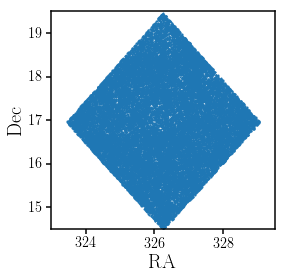

In [10]:
fig = plt.figure(figsize=(4,4)) 
sub = fig.add_subplot(111)
sub.scatter(mockdata['RA'], mockdata['DEC'], s=1)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim([323, 329.5])
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim([14.5, 19.5])

In [11]:
bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.


In [12]:
bgs_meta.keys()

['TEMPLATEID',
 'PASS',
 'APER',
 'RA',
 'DEC',
 'Z',
 'WEIGHT',
 'AGES_INFIBER_R',
 'INFIBER_R',
 'INFIBER_I',
 'VDISP',
 'SIGMA_KMS',
 'HBETA',
 'HBETA_EW',
 'HBETA_LIMIT',
 'HALPHAHBETA',
 'OIIIHBETA',
 'OIIHBETA',
 'NIIHBETA',
 'HBETA_CONTINUUM',
 'SDSS_UGRIZ_SYNTH',
 'SDSS_UGRIZ',
 'LOGMSTAR',
 'LOGSFR',
 'SDSS_UGRIZ_ABSMAG_Z01',
 'AV_ISM',
 'D4000',
 'D4000_SPEC']

In [28]:
for k in bgs_meta.keys():
    print k, bgs_meta[k].data[0]

TEMPLATEID 0
PASS 304
APER 218
RA 216.56916
DEC 32.642522
Z 0.1334
WEIGHT 1.15422
AGES_INFIBER_R 0.56515
INFIBER_R 0.14169
INFIBER_I 0.150841
VDISP 179.805
SIGMA_KMS 144.675
HBETA 4.91767e-17
HBETA_EW 2.29015
HBETA_LIMIT 0
HALPHAHBETA -999.0
OIIIHBETA -999.0
OIIHBETA -999.0
NIIHBETA -999.0
HBETA_CONTINUUM 5.49682e-12
SDSS_UGRIZ_SYNTH [ 21.51676941  20.12065697  19.14285278  18.62428284  18.28364754]
SDSS_UGRIZ [ 20.80298233  19.44526863  18.63536644  18.18705559  17.82072258]
LOGMSTAR 10.5509
LOGSFR 0.340417
SDSS_UGRIZ_ABSMAG_Z01 [-16.69156456 -18.13801575 -19.00478172 -19.50695419 -19.85606575]
AV_ISM 1.66097
D4000 1.33643
D4000_SPEC 1.52819


set up KDtree of BGS metadata

In [15]:
class BGStree(object):
    """Build a KD Tree from BGS template metadata."""
    def __init__(self):
        self.bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)
        self.bgs_tree = KDTree(self._bgs())

    def _bgs(self):
        """Quantities we care about: redshift (z), M_0.1r, and 0.1(g-r).
        """
        zobj = self.bgs_meta['Z'].data
        mabs = self.bgs_meta['SDSS_UGRIZ_ABSMAG_Z01'].data
        rmabs = mabs[:, 2]
        gr = mabs[:, 1] - mabs[:, 2]
        return np.vstack((zobj, rmabs, gr)).T        
    
    def query(self, objtype, matrix, subtype=''):
        """Return the nearest template number based on the KD Tree.

        Args:
          objtype (str): object type
          matrix (numpy.ndarray): (M,N) array (M=number of properties,
            N=number of objects) in the same format as the corresponding
            function for each object type (e.g., self.bgs).
          subtype (str, optional): subtype (only for white dwarfs)

        Returns:
          dist: distance to nearest template
          indx: index of nearest template
        
        """
        if objtype.upper() == 'BGS':
            dist, indx = self.bgs_tree.query(matrix)
        else:
            log.warning('Unrecognized SUBTYPE {}!'.format(subtype))
            raise ValueError
                
        return dist, indx

In [16]:
class BGStemplates(object):
    """Generate spectra.  

    """
    def __init__(self, wavemin=None, wavemax=None, dw=0.2, 
                 rand=None, verbose=False):
        self.tree = BGStree()

        # Build a default (buffered) wavelength vector.
        if wavemin is None:
            wavemin = load_throughput('b').wavemin - 10.0
        if wavemax is None:
            wavemax = load_throughput('z').wavemax + 10.0
            
        self.wavemin = wavemin
        self.wavemax = wavemax
        self.dw = dw
        self.wave = np.arange(round(wavemin, 1), wavemax, dw)

        self.rand = rand
        self.verbose = verbose

        # Initialize the templates once:
        self.bgs_templates = BGS(wave=self.wave, normfilter='sdss2010-r') # Need to generalize this!
        self.bgs_templates.normline = None # no emission lines!

    def bgs(self, data, index=None, mockformat='durham_mxxl_hdf5'):
        """Generate spectra for BGS.

        Currently only the MXXL (durham_mxxl_hdf5) mock is supported.  DATA
        needs to have Z, SDSS_absmag_r01, SDSS_01gr, VDISP, and SEED, which are
        assigned in mock.io.read_durham_mxxl_hdf5.  See also BGSKDTree.bgs().

        """
        objtype = 'BGS'
        if index is None:
            index = np.arange(len(data['Z']))
            
        input_meta = empty_metatable(nmodel=len(index), objtype=objtype)
        for inkey, datakey in zip(('SEED', 'MAG', 'REDSHIFT', 'VDISP'),
                                  ('SEED', 'MAG', 'Z', 'VDISP')):
            input_meta[inkey] = data[datakey][index]

        if mockformat.lower() == 'durham_mxxl_hdf5':
            alldata = np.vstack((data['Z'][index],
                                 data['SDSS_absmag_r01'][index],
                                 data['SDSS_01gr'][index])).T
            _, templateid = self.tree.query(objtype, alldata)
        else:
            raise ValueError('Unrecognized mockformat {}!'.format(mockformat))

        input_meta['TEMPLATEID'] = templateid
        flux, _, meta = self.bgs_templates.make_templates(input_meta=input_meta,
                                                          nocolorcuts=True, novdisp=False,
                                                          verbose=self.verbose)

        return flux, meta

In [18]:
BGSmaker = BGStemplates(wavemin=1500.0, wavemax=2e4, rand=simrand, verbose=False)

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


In [47]:
these = BGSmaker.rand.choice(len(mockdata['RA']), 50)
flux, meta = BGSmaker.bgs(mockdata, index=these)
keep = np.logical_or(isBGS_bright(rflux=meta['FLUX_R']), isBGS_faint(rflux=meta['FLUX_R']))

In [52]:
mockdata['SDSS_absmag_r01'][these][keep]

array([-21.63864326, -20.81587601, -20.47936058, -21.84616661,
       -18.55923462, -16.10333443, -19.61638069, -19.81557274,
       -19.72706223, -20.77402115, -19.58148384, -18.96858406,
       -20.51756859, -22.43827248, -19.45990944, -21.49036217,
       -20.04127693, -14.97762012, -19.93646622, -20.43586731,
       -21.04637718, -20.22803879, -21.85416412, -19.74294281,
       -19.98321342, -20.04705048, -20.05701637, -19.59831429], dtype=float32)

In [53]:
mockdata.keys()

['TRUESPECTYPE',
 'SDSS_01gr',
 'Z',
 'TEMPLATESUBTYPE',
 'FILTERNAME',
 'N_PER_FILE',
 'TEMPLATETYPE',
 'BRICKNAME',
 'VDISP',
 'OBJID',
 'MAG',
 'MOCKID',
 'DEC',
 'SEED',
 'FILES',
 'SDSS_absmag_r01',
 'RA']

In [62]:
flux[keep][0].shape

(92500,)

(1000.0, 20000.0)

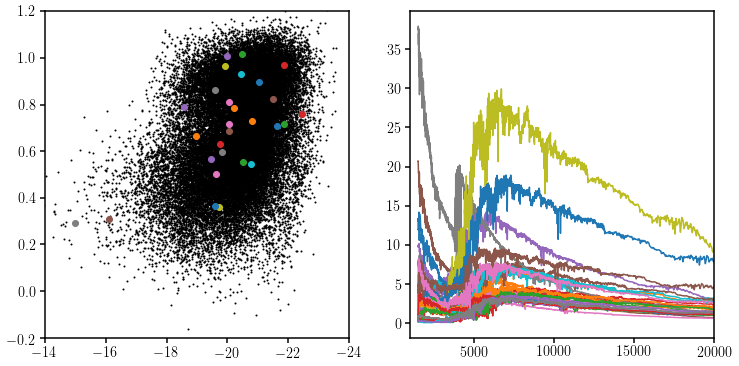

In [67]:
fig = plt.figure(figsize=(12,6))
sub1 = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
sub1.scatter(mockdata['SDSS_absmag_r01'], mockdata['SDSS_01gr'], c='k', s=1)
for i in range(np.sum(keep)): 
    sub1.scatter([mockdata['SDSS_absmag_r01'][these][keep][i]], [mockdata['SDSS_01gr'][these][keep][i]])
    sub2.plot(BGSmaker.wave, flux[keep][i])
sub1.set_xlim([-14, -24])
sub1.set_ylim([-0.2, 1.2])
sub2.set_xlim([1000., 20000.])    